# Calculate CESM2 POP2 heat budget using xgcm

This notebook is a templete for heat (trancer) budget analysis and to demostrate the buget closure for CESM2 POP using xgcm. In contrast to CESM1, CESM2 requires two additional terms to close heat budget. These are:

1) Temperature tendency due to Robert filter
2) Heat flux through the interface of the two Estuary Box Model (EBM) layers

This notebook is based on the notebook of [Anna-Lena Deppenmeier](https://github.com/ALDepp).

## Import packages and define functions

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from tqdm import tqdm

import pop_tools

## Load Dataset

In [3]:
fdir = '/glade/scratch/whokim/archive/g210.G_JRA.v14.gx1v7.01_TB/ocn/hist/'
ds = xr.open_dataset(fdir + 'g210.G_JRA.v14.gx1v7.01_TB.pop.h.0270-01.nc')

##
#### The next two cells are for the selection of a grid point where the vertical profile of the heat budget is illustrated below

In [4]:
def pop_find_lat_ind(loc, LATDAT):
    return np.abs(LATDAT[:, 0].values - loc).argmin()


def pop_find_lon_ind(loc, LONDAT, direction="w"):
    if direction.lower() in ["east", "e"]:
        value = loc
    elif direction.lower() in ["west", "w"]:
        value = 360 - loc
    else:
        print("I do not know which direction.")
    return np.nanargmin(np.abs(LONDAT[152, :].values - value))

In [5]:
# get lola inds from somewhere for indexing later on
lola_inds = {}
inds_lat = [-8, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 8]
for j in inds_lat:
    if j < 0:
        lola_inds["j_" + str(j)[1:] + "s"] = pop_find_lat_ind(j, ds.TLAT)
    else:
        lola_inds["j_" + str(j) + "n"] = pop_find_lat_ind(j, ds.TLAT)

inds_lon = range(95, 185, 5)
for i in inds_lon:
    lola_inds["i_" + str(i) + "_w"] = pop_find_lon_ind(i, ds.TLONG)

In [139]:
# just making sure everything works
# ds.TEMP.isel(z_t=0).mean(dim="time").plot(levels=np.arange(20, 30.5, 0.5), cmap="RdYlBu_r")
# ds.TEMP.isel(z_t=0).plot(levels=np.arange(20, 30.5, 0.5), cmap="RdYlBu_r")

# plt.scatter(lola_inds["i_140_w"], lola_inds["j_0n"], marker="*");

## Set up vertical thickness and volume for scaling

In [6]:
ds["DZT"] = xr.DataArray(ds.dz.values[:,None,None]*np.ones((len(ds.dz),len(ds.nlat),len(ds.nlon)))
                , dims=['z_t','nlat','nlon'], coords={'z_t':ds.z_t,'nlat':ds.nlat,'nlon':ds.nlon})
ds["DZU"] = xr.DataArray(ds.dz.values[:,None,None]*np.ones((len(ds.dz),len(ds.nlat),len(ds.nlon)))
                , dims=['z_t','nlat','nlon'], coords={'z_t':ds.z_t,'nlat':ds.nlat,'nlon':ds.nlon})

# DZU is not used in the script, but xgcm appears to require it

ds.DZT.attrs["long_name"] = "Thickness of T cells"
ds.DZT.attrs["units"] = "centimeter"
ds.DZT.attrs["grid_loc"] = "3111"
ds.DZU.attrs["long_name"] = "Thickness of U cells"
ds.DZU.attrs["units"] = "centimeter"
ds.DZU.attrs["grid_loc"] = "3221"

# make sure we have the cell volumne for calculations
VOL = (ds.dz * ds.DXT * ds.DYT).compute()
KMT = ds.KMT.compute()

for j in tqdm(range(len(KMT.nlat))):
    for i in range(len(KMT.nlon)):
        k = KMT.values[j, i].astype(int)
        VOL.values[k:, j, i] = 0.0

ds["VOL"] = VOL

ds.VOL.attrs["long_name"] = "volume of T cells"
ds.VOL.attrs["units"] = "centimeter^3"

ds.VOL.attrs["grid_loc"] = "3111"

100%|██████████| 384/384 [00:00<00:00, 887.96it/s]


## Set up dataset to gather budget terms

In [7]:
budget = xr.Dataset()

### Set grid and data set for xgcm with metrics

In [8]:
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],
}

# here we get the xgcm compatible dataset
gridxgcm, dsxgcm = pop_tools.to_xgcm_grid_dataset(
    ds,
    periodic=False,
    metrics=metrics,
    boundary={"X": "extend", "Y": "extend", "Z": "extend"},
)

for coord in ["nlat", "nlon"]:
    if coord in dsxgcm.coords:
        dsxgcm = dsxgcm.drop_vars(coord)

### 0) Tendency

In [9]:
budget['TEND_TEMP'] = dsxgcm.TEND_TEMP
budget['RF_TEND_TEMP'] = dsxgcm.RF_TEND_TEMP

### i) Total heat advection

In [10]:
budget["UET"] = -(gridxgcm.diff(dsxgcm.UET * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL)
budget["VNT"] = -(gridxgcm.diff(dsxgcm.VNT * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL)
budget["WTT"] = (
    gridxgcm.diff(dsxgcm.WTT.fillna(0) * (dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values, axis="Z")
    / dsxgcm.VOL
)
budget["TOT_ADV"] = budget["UET"] + budget["VNT"] + budget["WTT"]

### i-2) Total heat divergence due to parameterizations
These budget terms are not required to close the budget, but can be used for the breakdown of the advection term into resolved and parameterized advection terms

### ii) Heat flux due to vertical mixing:
includes surface flux at the 0th layer

In [11]:
budget["DIA_IMPVF_TEMP"] = -(
    gridxgcm.diff(dsxgcm.DIA_IMPVF_TEMP * dsxgcm.TAREA, axis="Z") / dsxgcm.VOL)

# set surface flux at 0th layer
SRF_TEMP_FLUX = (dsxgcm.SHF + dsxgcm.QFLUX - dsxgcm.SHF_QSW) * dsxgcm.hflux_factor

budget["DIA_IMPVF_TEMP"][:,0, :, :] = (
    SRF_TEMP_FLUX * dsxgcm.TAREA - dsxgcm.DIA_IMPVF_TEMP.isel(z_w_bot=0) * dsxgcm.TAREA
) / dsxgcm.VOL.values[0, :, :]

budget["KPP_SRC_TMP"] = dsxgcm.KPP_SRC_TEMP
budget["VDIF"] = budget["DIA_IMPVF_TEMP"] + budget["KPP_SRC_TMP"]

### iii) Heat flux due to horizontal diffusion

In [12]:
budget["HDIFE_TEMP"] = gridxgcm.diff(dsxgcm.HDIFE_TEMP * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL
budget["HDIFN_TEMP"] = gridxgcm.diff(dsxgcm.HDIFN_TEMP * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL

budget["HDIFB_TEMP"] = -(gridxgcm.diff(dsxgcm.HDIFB_TEMP * dsxgcm.VOL.values, axis="Z") / dsxgcm.VOL)
budget.HDIFB_TEMP[:,0,:,:] = - dsxgcm.HDIFB_TEMP[:,0,:,:]

budget["HDIF"] = budget["HDIFE_TEMP"] + budget["HDIFN_TEMP"] + budget["HDIFB_TEMP"]

### iv) Solar Penetration

In [13]:
budget["QSW_3D"] = -gridxgcm.diff((dsxgcm.QSW_3D * dsxgcm.hflux_factor), axis="Z") / dsxgcm.DZT

### v) Vertical flux due to EBM
The two methods below give the same results

In [14]:
budget["EBM"] = xr.DataArray(np.zeros((len(budget.time), len(budget.z_t), len(budget.nlat_t), 
                len(budget.nlon_t))), dims=['time', 'z_t', 'nlat_t', 'nlon_t'], 
                coords={'time':budget.time, 'z_t':budget.z_t, 'nlat_t':budget.nlat_t,'nlon_t':budget.nlon_t})

In [15]:
h = 2000.0

budget.EBM[:,0,:,:] = dsxgcm.T_FLUX_EXCH_INTRF.values*dsxgcm.z_w_bot[0].values/h
budget.EBM[:,1,:,:] = dsxgcm.T_FLUX_EXCH_INTRF.values*(h*2 - dsxgcm.z_w_bot[1].values)/h
budget.EBM[:,2,:,:] = dsxgcm.T_FLUX_EXCH_INTRF.values*(h*2 - dsxgcm.z_w_bot[2].values)/h

for j in tqdm(range(len(KMT.nlat))):
    for i in range(len(KMT.nlon)):
        k = KMT.values[j,i].astype(int)
        budget.EBM.values[:,k-1:,j,i] = 0.0
        
budget.EBM[:,1:5,:,:] = (budget.EBM.values[:,1:5,:,:] - budget.EBM.values[:,0:4,:,:])/dsxgcm.dz[0].values
budget.EBM[:,0,:,:] = budget.EBM.values[:,0,:,:]/dsxgcm.dz[0].values

100%|██████████| 384/384 [00:03<00:00, 97.22it/s]


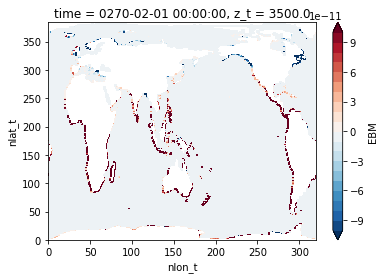

In [16]:
budget.EBM[0,3,:,:].plot(levels=np.arange(-1e-10, 1e-10, 1e-11))

### plot to make sure it closes

In [18]:
res = budget.TEND_TEMP - (budget.QSW_3D + budget.HDIF + budget.VDIF + budget.TOT_ADV 
                          + budget.RF_TEND_TEMP + budget.EBM)

#### Horizontal maps at some selected levels of the difference (or error) between the exact tendency and the sum of the right hand side

/glade/u/home/whokim/miniconda3/envs/rapcdi-analysis/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/glade/u/home/whokim/miniconda3/envs/rapcdi-analysis/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/glade/u/home/whokim/miniconda3/envs/rapcdi-analysis/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/glade/u/home/whokim/miniconda3/envs/rapcdi-analysis/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/glade/u/home/whokim/miniconda3/envs/rapcdi-analysis/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


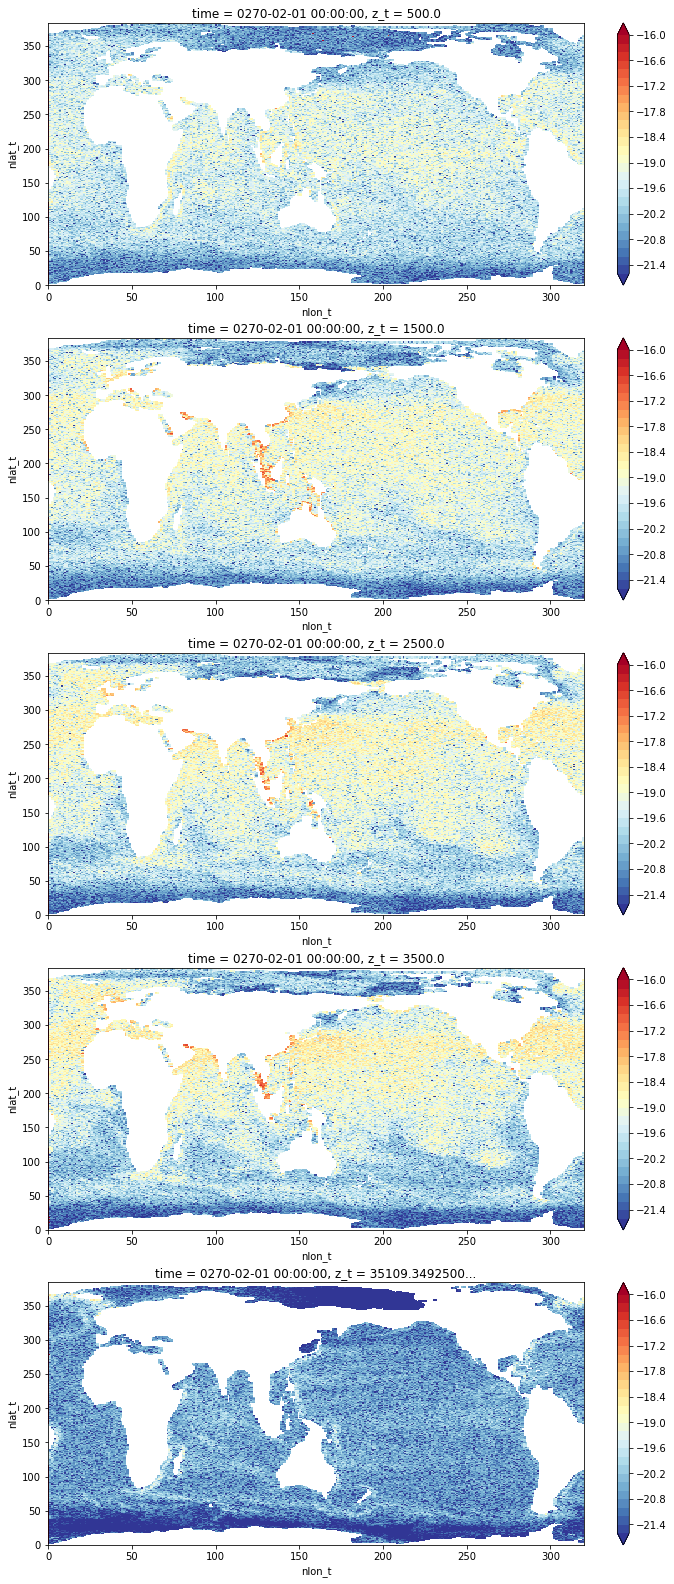

In [19]:
fig, ax = plt.subplots(5, 1, figsize=(12, 28), sharey=True)

for i in range(4):
    np.log10(abs(res.isel(z_t=i))).plot(levels=np.arange(-21.6 , -16, 0.2),cmap="RdYlBu_r",ax=ax[i])
np.log10(abs(res.isel(z_t=28))).plot(levels=np.arange(-21.6 , -16, 0.2),cmap="RdYlBu_r",ax=ax[4])

#### The vertical profiles of the error at two EBM locatione, one at the mouth of the Missisippi River and the other at the west coast of Columbia

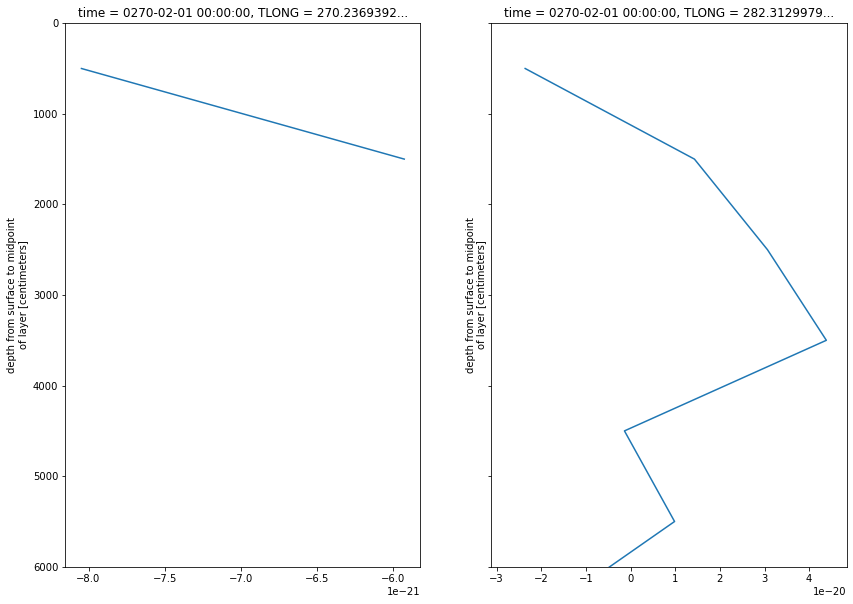

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 10), sharey=True)
res.isel(nlon_t=275, nlat_t=276).plot(y="z_t", ylim=(60e2, 0), 
                                      ax=ax[0])
res.isel(nlon_t=286, nlat_t=202).plot(y="z_t", ylim=(60e2, 0), ax=ax[1])

#### The vertical profiles of all budget terms and error at a selected grid point in the tropical Pacific

In [22]:
subset = budget.isel(nlon_t=lola_inds["i_180_w"], nlat_t=lola_inds["j_0n"], time=0)
# subset = budget.isel(nlon_t=lola_inds["i_180_w"], nlat_t=lola_inds["j_40n"])

CPU times: user 65.3 ms, sys: 7.25 ms, total: 72.5 ms
Wall time: 120 ms


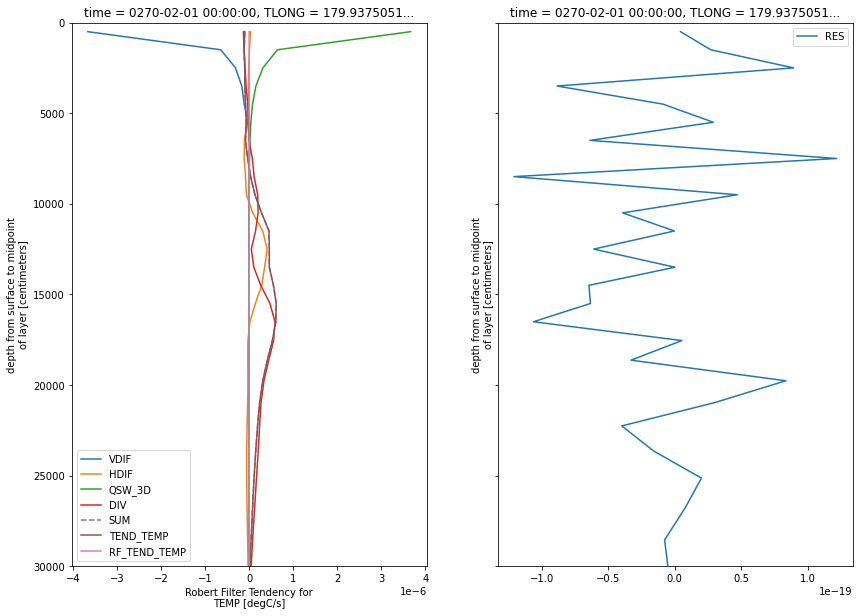

In [23]:
%%time

fig, ax = plt.subplots(1, 2, figsize=(14, 10), sharey=True)

# plot individual components
subset.VDIF.plot(y="z_t", ylim=(500e2, 0), label="VDIF", ax=ax[0])
subset.HDIF.plot(y="z_t", ylim=(500e2, 0), label="HDIF", ax=ax[0])
subset.QSW_3D.plot(y="z_t", ylim=(500e2, 0), label="QSW_3D", ax=ax[0])
subset.TOT_ADV.plot(y="z_t", ylim=(500e2, 0), label="DIV", ax=ax[0])
# subset.TOT_PARAM.plot(y="z_t", ylim=(500e2, 0), label="DIV_PARAM", ax=ax[0])

# plot sum
(subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV).plot(
    y="z_t", ylim=(500e2, 0), label="SUM", ls="--", ax=ax[0])

# plot tendency
subset.TEND_TEMP.plot(y="z_t", ylim=(500e2, 0), label="TEND_TEMP", ax=ax[0])
subset.RF_TEND_TEMP.plot(y="z_t", ylim=(500e2, 0), label="RF_TEND_TEMP", ax=ax[0])

ax[0].legend()

(subset.TEND_TEMP - (subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV + subset.RF_TEND_TEMP)).plot(
    y="z_t", ylim=(300e2, 0), label="RES", ax=ax[1])

# plot sum
# (subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV).plot(
#     y="z_t", ylim=(500e2, 0), xlim=(-1.6e-6, 1.1e-6), label="SUM", ls="--", ax=ax[1])

# plot tendency
# subset.TEND_TEMP.plot(y="z_t", ylim=(500e2, 0), xlim=(-3e-7, 3e-7), label="TEND_TEMP", ax=ax[1])
# subset.RF_TEND_TEMP.plot(y="z_t", ylim=(500e2, 0), xlim=(-5e-8, 5e-8), label="RF_TEND_TEMP", ax=ax[1])

ax[1].legend();

In [ ]:
# You may need to install watermark (conda install -c conda-forge watermark)
import xgcm  # just to display the version

%load_ext watermark
%watermark -d -iv -m -g
print("Above are the versions of the packages this works with.")